In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

batch_size = 8

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


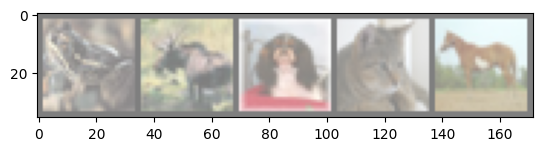

frog  deer  dog   cat   horse


In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:5]))

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(5)))

### **CUSTOM CNN**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


net = Net()

In [ ]:
import torch.optim as optim

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
for epoch in range(5):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.715
[1,  4000] loss: 1.445
[1,  6000] loss: 1.322
[2,  2000] loss: 1.200
[2,  4000] loss: 1.186
[2,  6000] loss: 1.149
[3,  2000] loss: 1.027
[3,  4000] loss: 1.017
[3,  6000] loss: 1.028
[4,  2000] loss: 0.882
[4,  4000] loss: 0.913
[4,  6000] loss: 0.899
[5,  2000] loss: 0.739
[5,  4000] loss: 0.795
[5,  6000] loss: 0.810
Finished Training


In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data

        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 61 %


### **ONE PIXEL ATTACK**

In [ ]:
def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

def tell(img, label, model, target_label=None):
    print("True Label:", classes[label], label)
    print("Prediction:", classes[model(img.unsqueeze(0)).max(-1)[1]], model(img.unsqueeze(0)).max(-1)[1][0].item())
    print("Label Probabilities:", F.softmax(model(img.unsqueeze(0)).squeeze(), dim=0))
    print("True Label Probability:", F.softmax(model(img.unsqueeze(0)).squeeze(), dim=0)[label].item())
    if target_label is not None:
        print("Target Label Probability:", F.softmax(model(img.unsqueeze(0)).squeeze(), dim=0)[target_label].item())

3
True Label: cat 3
Prediction: cat 3
Label Probabilities: tensor([3.4646e-04, 2.3657e-03, 1.1429e-02, 5.1192e-01, 1.8647e-03, 4.5925e-01,
        7.4509e-03, 1.4240e-03, 1.6654e-03, 2.2792e-03],
       grad_fn=<SoftmaxBackward0>)
True Label Probability: 0.5119216442108154
8
True Label: ship 8
Prediction: ship 8
Label Probabilities: tensor([1.0730e-01, 3.9739e-01, 2.8305e-03, 7.2987e-06, 7.8857e-06, 1.2989e-06,
        1.0998e-05, 3.9317e-05, 4.9223e-01, 1.8278e-04],
       grad_fn=<SoftmaxBackward0>)
True Label Probability: 0.49223408102989197
8
True Label: ship 8
Prediction: car 1
Label Probabilities: tensor([0.1453, 0.4179, 0.0384, 0.0031, 0.0016, 0.0012, 0.0004, 0.0081, 0.2801,
        0.1038], grad_fn=<SoftmaxBackward0>)
True Label Probability: 0.2800535261631012
0
True Label: plane 0
Prediction: ship 8
Label Probabilities: tensor([1.5045e-01, 3.1214e-03, 5.7371e-03, 2.3595e-03, 6.5143e-03, 2.3041e-04,
        7.6363e-05, 7.5762e-05, 8.2295e-01, 8.4862e-03],
       grad_fn=<Softma

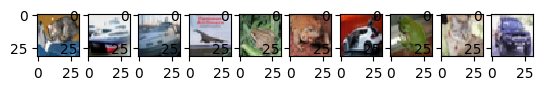

In [ ]:
for i in range(10):
  plt.subplot(1,10,i+1)
  test_img, test_label = testset[i]
  print(test_label)
  test_img = test_img.to(device)
  show(test_img)
  tell(test_img, test_label, net)

True Label: cat 3
Prediction: cat 3
Label Probabilities: tensor([4.7050e-04, 3.0674e-03, 1.4157e-02, 5.0914e-01, 2.9293e-03, 4.5476e-01,
        8.1617e-03, 2.1315e-03, 2.1185e-03, 3.0587e-03],
       grad_fn=<SoftmaxBackward0>)
True Label Probability: 0.5091428756713867
Next Example


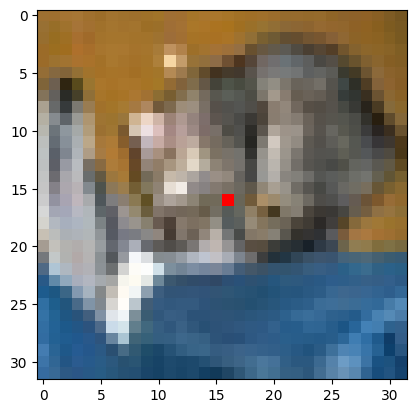

In [ ]:
def perturb(p, img):

    img_size = img.size(1) # C x _H_ x W, assume H == W
    p_img = img.clone()
    xy = (p[0:2].copy() * img_size).astype(int)
    xy = np.clip(xy, 0, img_size-1)
    rgb = p[2:5].copy()
    rgb = np.clip(rgb, 0, 1)
    p_img[:,xy[0],xy[1]] = torch.from_numpy(rgb)
    return p_img

p = np.array([0.5,0.5,255,0,0])

def visualize_perturbation(p, img, label, model, target_label=None):
    p_img = perturb(p, img)
#   print("Perturbation:", p)
    show(p_img)
    tell(p_img, label, model, target_label)
    print('Next Example')

test_img, test_label = testset[0]
visualize_perturbation(p, test_img, test_label, net)

In [ ]:
def evaluate(candidates, img, label, model):
    preds = []
    model.eval()
    with torch.no_grad():
        for i, xs in enumerate(candidates):
            p_img = perturb(xs, img)
            preds.append(F.softmax(model(p_img.unsqueeze(0)).squeeze(), dim=0)[label].item())
    return np.array(preds)

def evolve(candidates, F=0.5, strategy="clip"):
    gen2 = candidates.copy()
    num_candidates = len(candidates)
    for i in range(num_candidates):
        x1, x2, x3 = candidates[np.random.choice(num_candidates, 3, replace=False)]
        x_next = (x1 + F*(x2 - x3))
        if strategy == "clip":
            gen2[i] = np.clip(x_next, 0, 1)
        elif strategy == "resample":
            x_oob = np.logical_or((x_next < 0), (1 < x_next))
            x_next[x_oob] = np.random.random(5)[x_oob]
            gen2[i] = x_next
    return gen2

def attack(model, img, true_label, target_label=None, iters=100, pop_size=400, verbose=True):
    candidates = np.random.random((pop_size,5))
    candidates[:,2:5] = np.clip(np.random.normal(0.5, 0.5, (pop_size, 3)), 0, 1)
    is_targeted = target_label is not None
    label = target_label if is_targeted else true_label
    fitness = evaluate(candidates, img, label, model)

    def is_success():
        return (is_targeted and fitness.max() > 0.5) or ((not is_targeted) and fitness.min() < 0.05)

    for iteration in range(iters):
        if is_success():
            break
        if verbose and iteration%25 == 0: # Print progress
            print("Target Probability [Iteration {}]:".format(iteration), fitness.max() if is_targeted else fitness.min())

        new_gen_candidates = evolve(candidates, strategy="resample")

        new_gen_fitness = evaluate(new_gen_candidates, img, label, model)

        successors = new_gen_fitness > fitness if is_targeted else new_gen_fitness < fitness
        candidates[successors] = new_gen_candidates[successors]
        fitness[successors] = new_gen_fitness[successors]
    best_idx = fitness.argmax() if is_targeted else fitness.argmin()
    best_solution = candidates[best_idx]
    best_score = fitness[best_idx]
    if verbose:
        visualize_perturbation(best_solution, img, true_label, model, target_label)
    return is_success(), best_solution, best_score

Target Probability [Iteration 0]: 0.3914031386375427
Target Probability [Iteration 25]: 0.3914031386375427
Target Probability [Iteration 50]: 0.3691875636577606
Target Probability [Iteration 75]: 0.32955697178840637
True Label: cat 3
Prediction: dog 5
Label Probabilities: tensor([1.2483e-04, 8.6860e-04, 6.8495e-03, 3.2120e-01, 7.7779e-04, 6.6304e-01,
        4.3456e-03, 6.9526e-04, 1.0029e-03, 1.0924e-03],
       grad_fn=<SoftmaxBackward0>)
True Label Probability: 0.3212040066719055
Next Example


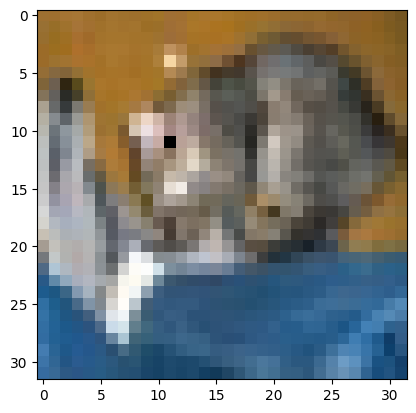

In [ ]:
_ = attack(net, test_img, test_label)

In [ ]:
targeted_results = {}

test_img, test_label = testset[0]
for idx in range(len(classes)):
  if idx != test_label:
      targeted_results[idx] = attack(net, test_img, test_label, target_label=idx, iters=20, verbose=False)
      print(classes[idx], idx, targeted_results[idx][0], targeted_results[idx][2])
  else:
      print(classes[idx], idx,  "True Label")

plane 0 False 0.0009897974086925387
car 1 False 0.005646431818604469
bird 2 False 0.024900374934077263
cat 3 True Label
deer 4 False 0.005693418905138969
dog 5 True 0.5355352163314819
frog 6 False 0.018066082149744034
horse 7 False 0.004617865663021803
ship 8 False 0.005988627206534147
truck 9 False 0.00545126385986805


True Label: frog 6
Prediction: frog 6
Label Probabilities: tensor([3.4938e-03, 6.8549e-06, 4.0838e-01, 9.2613e-02, 2.8580e-02, 2.8106e-02,
        4.3692e-01, 4.6017e-04, 9.8449e-04, 4.5480e-04],
       grad_fn=<SoftmaxBackward0>)
True Label Probability: 0.4369177222251892
Next Example
Target Probability [Iteration 0]: 0.3557521402835846
Target Probability [Iteration 25]: 0.28988948464393616
Target Probability [Iteration 50]: 0.2584129273891449
Target Probability [Iteration 75]: 0.2394692301750183
True Label: frog 6
Prediction: bird 2
Label Probabilities: tensor([2.5266e-03, 5.5037e-05, 5.3944e-01, 1.4904e-01, 4.2552e-02, 1.9981e-02,
        2.3755e-01, 5.7713e-03, 7.1323e-04, 2.3677e-03],
       grad_fn=<SoftmaxBackward0>)
True Label Probability: 0.23754844069480896
Next Example


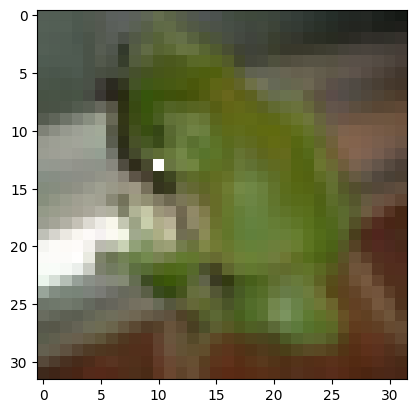

In [ ]:
test_img, test_label = testset[7]
visualize_perturbation(p, test_img, test_label, net)
test_img, test_label = testset[7]
_ = attack(net, test_img, test_label)

targeted_results = {}

In [ ]:
test_img, test_label = testset[7]
for idx in range(len(classes)):
  if idx != test_label:
      targeted_results[idx] = attack(net, test_img, test_label, target_label=idx, iters=20, verbose=False)
      print(classes[idx], idx, targeted_results[idx][0], targeted_results[idx][2])
  else:
      print(classes[idx], idx,  "True Label")

plane 0 False 0.00647503649815917
car 1 False 6.697337084915489e-05
bird 2 True 0.5339181423187256
cat 3 False 0.1877264380455017
deer 4 False 0.054848216474056244
dog 5 False 0.05652691796422005
frog 6 True Label
horse 7 False 0.0033473519142717123
ship 8 False 0.006460401229560375
truck 9 False 0.0030198944732546806


True Label: cat 3
Prediction: cat 3
Label Probabilities: tensor([5.8542e-03, 9.6692e-05, 1.0012e-01, 5.4061e-01, 4.9602e-02, 2.3790e-01,
        2.9214e-02, 3.3918e-02, 1.5119e-03, 1.1714e-03],
       grad_fn=<SoftmaxBackward0>)
True Label Probability: 0.5406119227409363
Next Example
Target Probability [Iteration 0]: 0.42326676845550537
Target Probability [Iteration 25]: 0.36294469237327576
Target Probability [Iteration 50]: 0.31420502066612244
Target Probability [Iteration 75]: 0.2954674959182739
True Label: cat 3
Prediction: dog 5
Label Probabilities: tensor([5.0486e-03, 1.2436e-05, 1.5160e-01, 2.8937e-01, 2.3349e-02, 4.7738e-01,
        9.7961e-03, 4.2685e-02, 4.3881e-04, 3.1845e-04],
       grad_fn=<SoftmaxBackward0>)
True Label Probability: 0.28937244415283203
Next Example


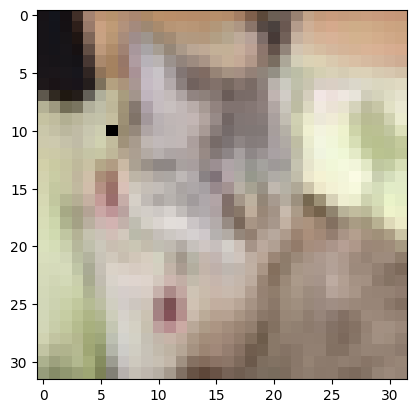

In [ ]:
test_img, test_label = testset[8]
visualize_perturbation(p, test_img, test_label, net)
test_img, test_label = testset[8]
_ = attack(net, test_img, test_label)

targeted_results = {}

In [ ]:
test_img, test_label = testset[8]
for idx in range(len(classes)):
  if idx != test_label:
      targeted_results[idx] = attack(net, test_img, test_label, target_label=idx, iters=20, verbose=False)
      print(classes[idx], idx, targeted_results[idx][0], targeted_results[idx][2])
  else:
      print(classes[idx], idx,  "True Label")

plane 0 False 0.015546899288892746
car 1 False 0.00046057160943746567
bird 2 False 0.2003057599067688
cat 3 True Label
deer 4 False 0.08049915730953217
dog 5 False 0.435611367225647
frog 6 False 0.06007632240653038
horse 7 False 0.07859569787979126
ship 8 False 0.004753924906253815
truck 9 False 0.0034336443059146404


### **CNN-ATTENTION**

In [ ]:
import torch
import torch.nn as nn

class channel_attention_module(nn.Module):
    def __init__(self, ch, ratio=8):
        super().__init__()

        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.mlp = nn.Sequential(
            nn.Linear(ch, ch//ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(ch//ratio, ch, bias=False)
        )

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x1 = self.avg_pool(x).squeeze(-1).squeeze(-1)
        x1 = self.mlp(x1)

        x2 = self.max_pool(x).squeeze(-1).squeeze(-1)
        x2 = self.mlp(x2)

        feats = x1 + x2
        feats = self.sigmoid(feats).unsqueeze(-1).unsqueeze(-1)
        refined_feats = x * feats

        return refined_feats


class spatial_attention_module(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()

        self.conv = nn.Conv2d(2, 1, kernel_size, padding=3, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x1 = torch.mean(x, dim=1, keepdim=True)
        x2, _ = torch.max(x, dim=1, keepdim=True)

        feats = torch.cat([x1, x2], dim=1)
        feats = self.conv(feats)
        feats = self.sigmoid(feats)
        refined_feats = x * feats

        return refined_feats

class cbam(nn.Module):
    def __init__(self, channel):
        super().__init__()

        self.ca = channel_attention_module(channel)
        self.sa = spatial_attention_module()

    def forward(self, x):
        x = self.ca(x)
        x = self.sa(x)
        return x

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 32, 5)
        self.cbam = cbam(32)
        self.fc1 = nn.Linear(32 * 5 * 5 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.cbam(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


net1 = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net1.parameters(), lr=0.001)


for epoch in range(5):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.788
[1,  4000] loss: 1.500
[1,  6000] loss: 1.385
[2,  2000] loss: 1.254
[2,  4000] loss: 1.230
[2,  6000] loss: 1.187
[3,  2000] loss: 1.079
[3,  4000] loss: 1.050
[3,  6000] loss: 1.034
[4,  2000] loss: 0.891
[4,  4000] loss: 0.905
[4,  6000] loss: 0.910
[5,  2000] loss: 0.728
[5,  4000] loss: 0.746
[5,  6000] loss: 0.766
Finished Training


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data

        outputs = net1(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 61 %


Target Probability [Iteration 0]: 0.5788998603820801
Target Probability [Iteration 25]: 0.5129252672195435
Target Probability [Iteration 50]: 0.5129252672195435
Target Probability [Iteration 75]: 0.48986539244651794
True Label: cat 3
Prediction: cat 3
Label Probabilities: tensor([5.8579e-03, 2.8935e-02, 1.5238e-02, 4.7991e-01, 1.0839e-03, 1.2654e-01,
        2.5566e-01, 1.0259e-03, 8.5591e-02, 1.6183e-04],
       grad_fn=<SoftmaxBackward0>)
True Label Probability: 0.47991055250167847
Next Example


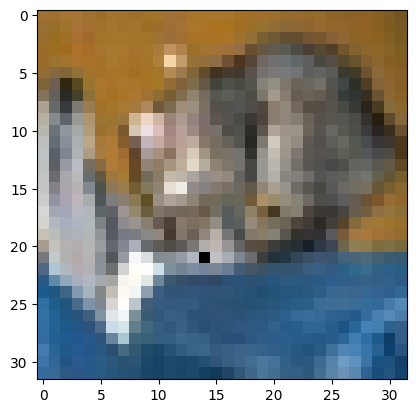

In [ ]:
# Untargeted attack
test_img, test_label = testset[0]
_ = attack(net1, test_img, test_label)

In [ ]:
test_img, test_label = testset[0]
targeted_results = {}
for idx in range(len(classes)):
    if idx != test_label:
        targeted_results[idx] = attack(net1, test_img, test_label, target_label=idx, iters=20, verbose=False)
        print(classes[idx], idx, targeted_results[idx][0], targeted_results[idx][2])
    else:
        print(classes[idx], idx,  "True Label")

plane 0 False 0.006312856450676918
car 1 False 0.04356294125318527
bird 2 False 0.019737020134925842
cat 3 True Label
deer 4 False 0.0014523749705404043
dog 5 False 0.18946529924869537
frog 6 False 0.27599039673805237
horse 7 False 0.0008324161171913147
ship 8 False 0.13305942714214325
truck 9 False 0.00028566745459102094


Target Probability [Iteration 0]: 0.32264766097068787
Target Probability [Iteration 25]: 0.25617003440856934
Target Probability [Iteration 50]: 0.24369148910045624
Target Probability [Iteration 75]: 0.24226702749729156
True Label: frog 6
Prediction: bird 2
Label Probabilities: tensor([3.0801e-03, 2.3376e-04, 7.4566e-01, 6.2457e-03, 4.5355e-05, 2.4167e-03,
        2.4204e-01, 5.3545e-06, 2.3363e-04, 3.8332e-05],
       grad_fn=<SoftmaxBackward0>)
True Label Probability: 0.24204233288764954
Next Example


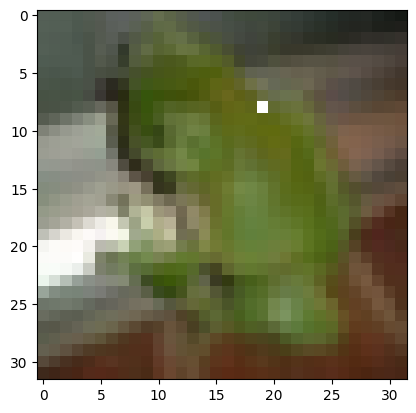

In [ ]:
test_img, test_label = testset[7]
_ = attack(net1, test_img, test_label)

In [ ]:

targeted_results = {}
test_img, test_label = testset[7]
for idx in range(len(classes)):
    if idx != test_label:
        targeted_results[idx] = attack(net1, test_img, test_label, target_label=idx, iters=20, verbose=False)
        print(classes[idx], idx, targeted_results[idx][0], targeted_results[idx][2])
    else:
        print(classes[idx], idx,  "True Label")

plane 0 False 0.007408078294247389
car 1 False 0.001124481437727809
bird 2 True 0.6973822712898254
cat 3 False 0.010981357656419277
deer 4 False 0.00017071940237656236
dog 5 False 0.0029878641944378614
frog 6 True Label
horse 7 False 1.3662988749274518e-05
ship 8 False 0.0005518632242456079
truck 9 False 0.00010565338016021997


Target Probability [Iteration 0]: 0.4842471778392792
Target Probability [Iteration 25]: 0.43379324674606323
Target Probability [Iteration 50]: 0.405402272939682
Target Probability [Iteration 75]: 0.39273306727409363
True Label: cat 3
Prediction: cat 3
Label Probabilities: tensor([3.1607e-04, 1.3338e-04, 4.4659e-02, 3.8869e-01, 1.5368e-01, 3.3039e-01,
        2.0682e-03, 7.9920e-02, 1.5736e-05, 1.2323e-04],
       grad_fn=<SoftmaxBackward0>)
True Label Probability: 0.3886934220790863
Next Example


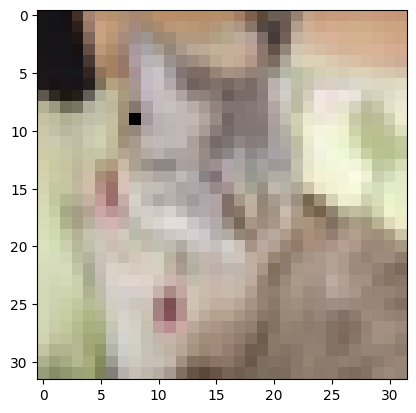

In [ ]:
test_img, test_label = testset[8]
_ = attack(net1, test_img, test_label)

In [ ]:
# Targeted attack
# This is much harder/costlier than an untargeted attack
# For time reasons, targeted attacks below use 20 iterations
targeted_results = {}
test_img, test_label = testset[8]
for idx in range(len(classes)):
    if idx != test_label:
        targeted_results[idx] = attack(net1, test_img, test_label, target_label=idx, iters=20, verbose=False)
        print(classes[idx], idx, targeted_results[idx][0], targeted_results[idx][2])
    else:
        print(classes[idx], idx,  "True Label")

plane 0 False 0.0006650613504461944
car 1 False 0.00022605204139836133
bird 2 False 0.06833626329898834
cat 3 True Label
deer 4 False 0.18122822046279907
dog 5 False 0.3234300911426544
frog 6 False 0.0029469523578882217
horse 7 False 0.09572989493608475
ship 8 False 6.613791629206389e-05
truck 9 False 0.0003029480576515198
